In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


Found 159 image files and 159 label files.
Image shape: (240, 240, 155), dtype: float64
Label shape: (240, 240, 155), unique values: [0. 1. 2. 3.]


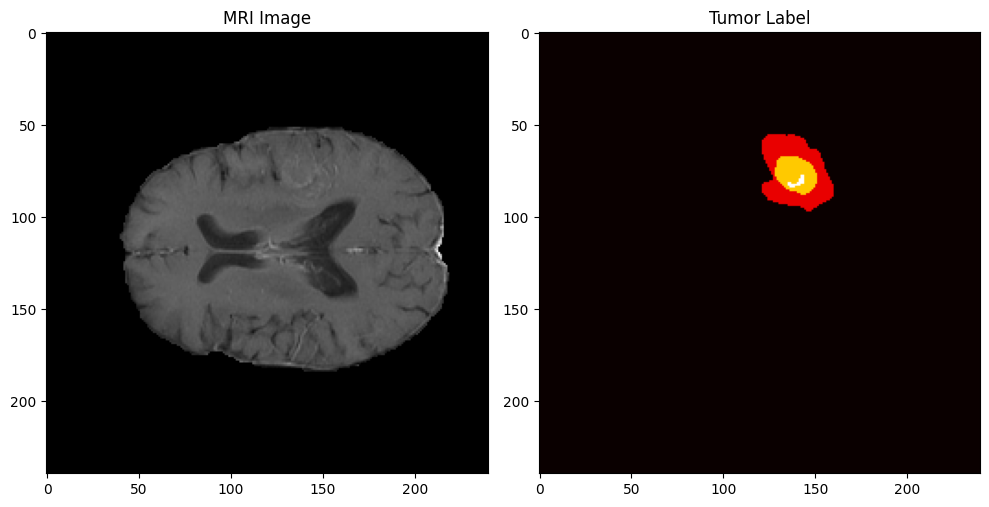

In [8]:

# Path to your dataset
image_dir = '/Users/mxvp/Documents/Stanford/thesis/brain/data/TCGA_set2_images'
label_dir = '/Users/mxvp/Documents/Stanford/thesis/brain/data/TCGA_set2_labels'

# Load paths
image_files = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_files = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

print(f"Found {len(image_files)} image files and {len(label_files)} label files.")

# Load one image and label
img = nib.load(image_files[2])
label = nib.load(label_files[2])

img_data = img.get_fdata()
label_data = label.get_fdata()

print(f"Image shape: {img_data.shape}, dtype: {img_data.dtype}")
print(f"Label shape: {label_data.shape}, unique values: {np.unique(label_data)}")

# Show some slices
def show_slices(image, label, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2  # middle slice
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image[:, :, slice_idx], cmap='gray')
    axs[0].set_title("MRI Image")
    axs[1].imshow(label[:, :, slice_idx], cmap='hot')
    axs[1].set_title("Tumor Label")
    plt.tight_layout()
    plt.show()

show_slices(img_data, label_data)


In [3]:
print(label.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : -0.0
qoffset_y       : 239.0
qoffset_z       : 0.0

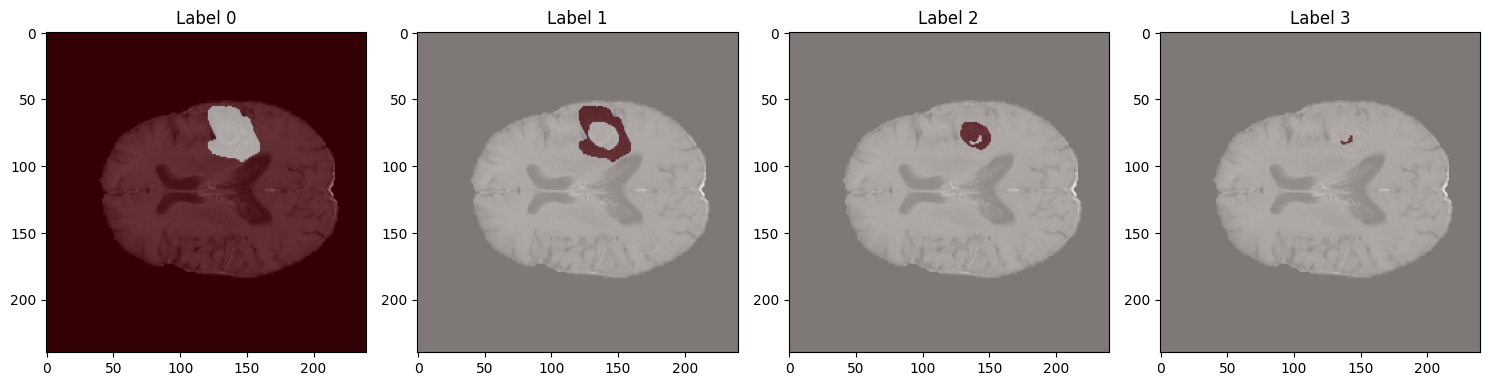

In [9]:
def show_label_classes(image, label, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2

    fig, axs = plt.subplots(1, len(np.unique(label)), figsize=(15, 5))
    for i, label_val in enumerate(np.unique(label)):
        mask = label[:, :, slice_idx] == label_val
        axs[i].imshow(image[:, :, slice_idx], cmap='gray')
        axs[i].imshow(mask, cmap='Reds', alpha=0.5)
        axs[i].set_title(f"Label {int(label_val)}")
    plt.tight_layout()
    
    plt.show()

show_label_classes(img_data, label_data)


Number of cases: 495
Mean bbox size (z, y, x): [58.58585859 79.48888889 62.78585859]
Max bbox size (z, y, x): [156 173 138]
Min bbox size (z, y, x): [17 17 15]


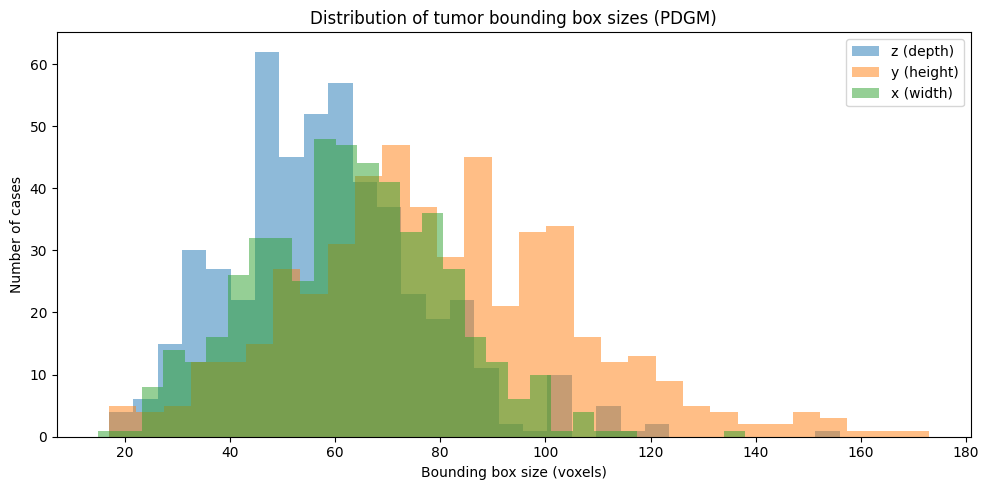

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Directory containing PDGM cases
PDGM_DIR = "/oak/stanford/groups/ogevaert/data/brain_mri_tumor_project/UCSF-PDGM-v3"

bbox_sizes = []

for case_folder in sorted(os.listdir(PDGM_DIR)):
    if not case_folder.startswith("UCSF-PDGM-"):
        continue
    case_path = os.path.join(PDGM_DIR, case_folder)
    num4 = case_folder.split("-")[-1].split("_")[0]
    file_case_id = f"UCSF-PDGM-{num4}"
    mask_path = os.path.join(case_path, f"{file_case_id}_tumor_segmentation.nii.gz")
    if not os.path.exists(mask_path):
        continue
    mask = nib.load(mask_path).get_fdata()
    if np.sum(mask) == 0:
        continue  # skip empty masks
    coords = np.array(np.where(mask > 0))
    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)
    bbox_shape = (zmax - zmin + 1, ymax - ymin + 1, xmax - xmin + 1)
    bbox_sizes.append(bbox_shape)

bbox_sizes = np.array(bbox_sizes)
print(f"Number of cases: {len(bbox_sizes)}")
print("Mean bbox size (z, y, x):", np.mean(bbox_sizes, axis=0))
print("Max bbox size (z, y, x):", np.max(bbox_sizes, axis=0))
print("Min bbox size (z, y, x):", np.min(bbox_sizes, axis=0))

plt.figure(figsize=(10,5))
plt.hist(bbox_sizes[:,0], bins=30, alpha=0.5, label='z (depth)')
plt.hist(bbox_sizes[:,1], bins=30, alpha=0.5, label='y (height)')
plt.hist(bbox_sizes[:,2], bins=30, alpha=0.5, label='x (width)')
plt.xlabel("Bounding box size (voxels)")
plt.ylabel("Number of cases")
plt.legend()
plt.title("Distribution of tumor bounding box sizes (PDGM)")
plt.tight_layout()
plt.show()